In [1]:
import pandas as pd

In [ ]:

# Load processed monthly prices

processed_path = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\processed\monthly_prices.csv"

df = pd.read_csv(processed_path, parse_dates=['Date'])
df.set_index('Date', inplace=True)

# Select TSLA only for this modelling test since its the most volatile
tsla_prices = df[['TSLA']].dropna()

print("TSLA data shape:", tsla_prices.shape)
display(tsla_prices.head())

TSLA data shape: (133, 1)


,TSLA
Date,
2015-01-31,13.573333
2015-02-28,13.556000
2015-03-31,12.584667
2015-04-30,15.070000
2015-05-31,16.719999


In [3]:
# Time-based train-test split
# data till 2025 will serve as train dataset and 2025 and above serves as test dataset
train = tsla_prices.loc[:'2024-12-31']
test  = tsla_prices.loc['2025-01-01':]

print("\nTrain period:", train.index.min(), "→", train.index.max())
print("Test period :", test.index.min(), "→", test.index.max())

print("\nTrain shape:", train.shape)
print("Test shape :", test.shape)


Train period: 2015-01-31 00:00:00 → 2024-12-31 00:00:00
Test period : 2025-01-31 00:00:00 → 2026-01-31 00:00:00

Train shape: (120, 1)
Test shape : (13, 1)


In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test on TSLA training data
# for the ARIMA model to work it need to be stationary so volatility check is needed
adf_result = adfuller(train['TSLA'])

print("ADF Test on TSLA Training Prices")
print(f"Test Statistic : {adf_result[0]:.4f}")
print(f"p-value        : {adf_result[1]:.4f}")
print(f"# Lags used    : {adf_result[2]}")
print(f"# Observations : {adf_result[3]}")

if adf_result[1] < 0.05:
    print("→ TSLA prices are stationary (reject H0)")
else:
    print("→ TSLA prices are NON-stationary (fail to reject H0)")


ADF Test on TSLA Training Prices
Test Statistic : -0.3135
p-value        : 0.9236
# Lags used    : 0
# Observations : 119
→ TSLA prices are NON-stationary (fail to reject H0)


In [ ]:
# needed to apply differncing since it is stationary
# First differencing
tsla_diff = train['TSLA'].diff().dropna()


# ADF test after differencing

adf_diff = adfuller(tsla_diff)

print("ADF Test on Differenced TSLA Prices")
print(f"Test Statistic : {adf_diff[0]:.4f}")
print(f"p-value        : {adf_diff[1]:.4f}")
print(f"# Lags used    : {adf_diff[2]}")
print(f"# Observations : {adf_diff[3]}")

if adf_diff[1] < 0.05:
    print("→ Differenced TSLA series IS stationary (reject H0)")
else:
    print("→ Differenced TSLA series is STILL non-stationary")


ADF Test on Differenced TSLA Prices
Test Statistic : -4.2535
p-value        : 0.0005
# Lags used    : 3
# Observations : 115
→ Differenced TSLA series IS stationary (reject H0)


In [ ]:
from pmdarima import auto_arima

# Auto ARIMA to find (p, d, q)
auto_model = auto_arima(
    train['TSLA'],
    start_p=0,
    start_q=0,
    max_p=5,
    max_q=5,
    d=1,                 # confirmed by ADF test
    seasonal=False,      # monthly data, no clear seasonality assumed
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print(auto_model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1134.558, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1136.480, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1136.464, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1134.182, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.225 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -566.091
Date:                Thu, 29 Jan 2026   AIC                           1134.182
Time:                        17:57:48   BIC                           1136.961
Sample:                    01-31-2015   HQIC                          1135.311
                         - 12-31-2024                                         
Co

The model tried to find patterns in Tesla’s past prices, but the best model says there are no useful patterns prices mostly move randomly from one period to the next.

## Test and Evaluate ARIMA model

                               SARIMAX Results                                
Dep. Variable:                   TSLA   No. Observations:                  120
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -566.091
Date:                Thu, 29 Jan 2026   AIC                           1134.182
Time:                        18:16:07   BIC                           1136.961
Sample:                    01-31-2015   HQIC                          1135.311
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       793.3563     63.590     12.476      0.000     668.723     917.990
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                56.16
Prob(Q):                              0.78   Pr

c:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


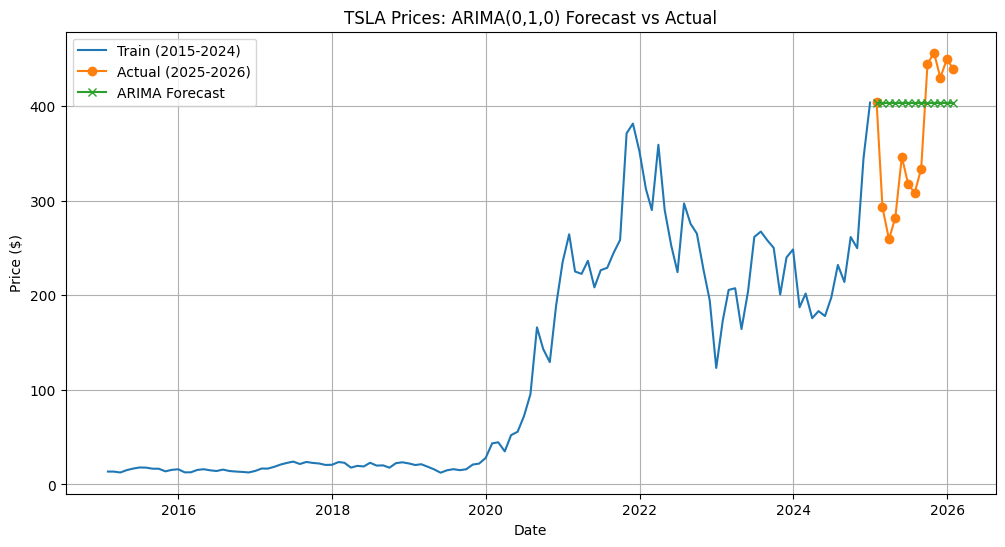

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

#  re-fit using ARIMA from statsmodels for easier forecasting
arima_model = ARIMA(train, order=(0,1,0))
arima_fit = arima_model.fit()
print(arima_fit.summary())

# Forecast for test period
forecast_steps = len(test)
arima_forecast = arima_fit.forecast(steps=forecast_steps)

# Evaluate Forecast
mae = mean_absolute_error(test, arima_forecast)
rmse = np.sqrt(mean_squared_error(test, arima_forecast))
mape = np.mean(np.abs((test - arima_forecast) / test)) * 100

print(f"\nARIMA(0,1,0) Forecast Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# Plot Actual vs Forecast
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label='Train (2015-2024)')
plt.plot(test.index, test, label='Actual (2025-2026)', marker='o')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', marker='x')
plt.title("TSLA Prices: ARIMA(0,1,0) Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


TSLA prices were non-stationary, so we applied first-order differencing to make the series stationary.
The ARIMA(0,1,0) model was fitted on 2015–2024 data and used to forecast 2025–2026.
Forecast errors: MAE ≈ 68, RMSE ≈ 79.
ARIMA captures the overall trend but misses sudden spikes.

### LSTM Forecasting for TSLA

X_train shape: (108, 12, 1)
X_test shape : (13, 12, 1)
Epoch 1/50


c:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0545 
Epoch 2/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112
Epoch 3/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099
Epoch 4/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0088
Epoch 5/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090
Epoch 6/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0081
Epoch 7/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0087
Epoch 8/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 9/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0078
Epoch 10/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078
Epoch 11/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0073
Epoch 12/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 13/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067
Epoch 14/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0072
Epoch 15/50
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0064

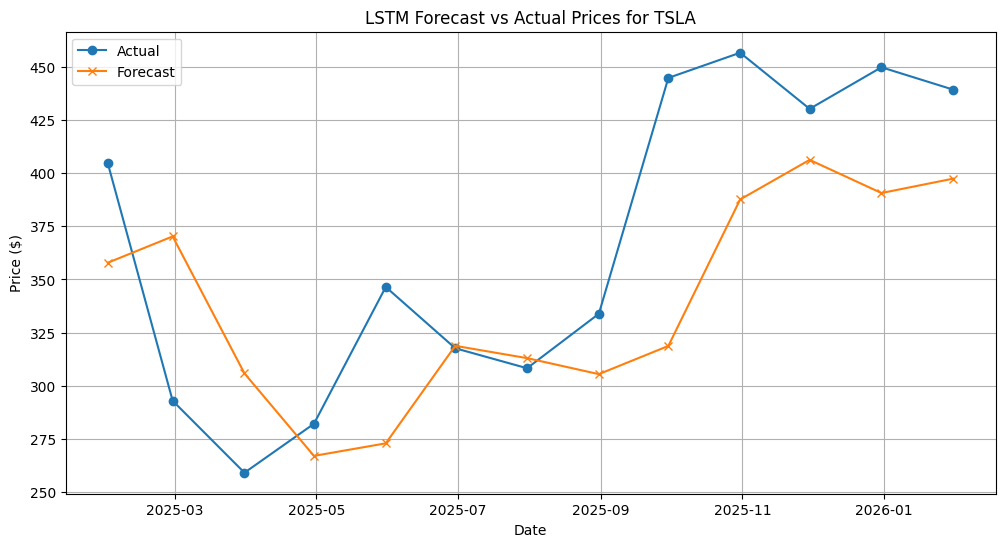

In [ ]:

import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

# -----------------------------
# Scale prices to 0-1 for LSTM
# -----------------------------
scaler = MinMaxScaler(feature_range=(0, 1))
tsla_scaled = scaler.fit_transform(tsla_prices)

# -----------------------------
# Create sequences for LSTM
# Using last 12 months to predict next month
# -----------------------------
def create_sequences(data, seq_length=12):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 12
X, y = create_sequences(tsla_scaled, seq_length)

# -----------------------------
# Split chronologically into train/test
# -----------------------------
train_size = int(len(X) * 0.9)  # ~90% train, 10% test
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)

# -----------------------------
# Build LSTM Model
# -----------------------------
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(seq_length, 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# -----------------------------
# Train Model
# -----------------------------
history = model.fit(X_train, y_train, epochs=50, batch_size=1, verbose=1)

# -----------------------------
# Forecast / Predict
# -----------------------------
y_pred = model.predict(X_test)

# Inverse scale to original prices
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# -----------------------------
# Evaluate Forecast
# -----------------------------
mae = np.mean(np.abs(y_test_orig - y_pred_orig))
rmse = np.sqrt(np.mean((y_test_orig - y_pred_orig)**2))
mape = np.mean(np.abs((y_test_orig - y_pred_orig)/y_test_orig)) * 100

print("\nLSTM Forecast Evaluation Metrics:")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")

# -----------------------------
# Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(tsla_prices.index[-len(y_test_orig):], y_test_orig, label='Actual', marker='o')
plt.plot(tsla_prices.index[-len(y_test_orig):], y_pred_orig, label='Forecast', marker='x')
plt.title('LSTM Forecast vs Actual Prices for TSLA')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(True)
plt.show()


The LSTM model captures the overall trend of TSLA prices and provides reasonably accurate forecasts for short-term monthly predictions. The MAPE of ~12.7% indicates moderate prediction error, which is expected given TSLA's high volatility.

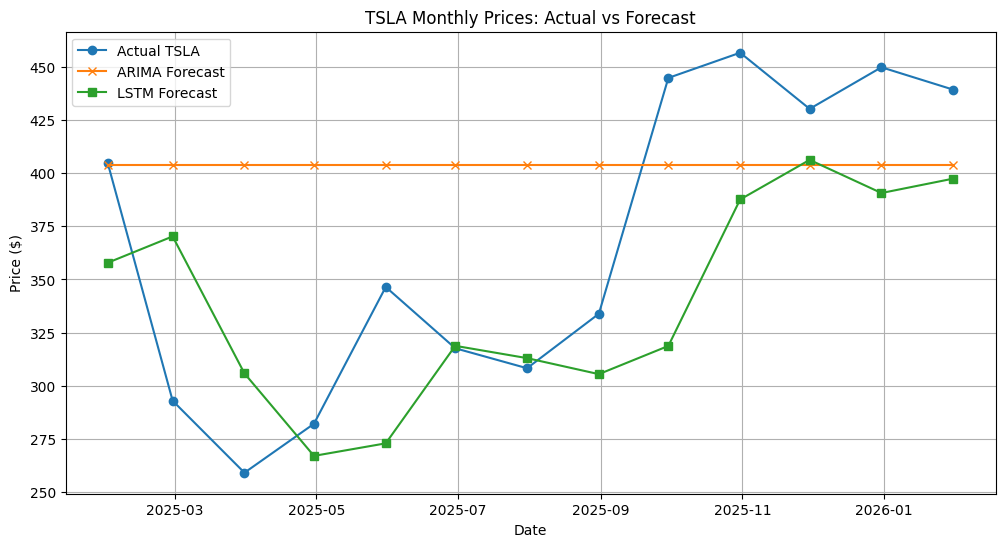

In [14]:
# Define variables for plotting
lstm_forecast = y_pred_orig.flatten()
actual_test = y_test_orig.flatten()  # corresponds to your LSTM test set
test_index = tsla_prices.index[-len(y_test_orig):]  # get the dates for test set

# Plot Actual vs Forecast (ARIMA + LSTM)
plt.figure(figsize=(12,6))
plt.plot(test_index, actual_test, label='Actual TSLA', marker='o')
plt.plot(test_index, arima_forecast, label='ARIMA Forecast', marker='x')
plt.plot(test_index, lstm_forecast, label='LSTM Forecast', marker='s')
plt.title("TSLA Monthly Prices: Actual vs Forecast")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.show()


## Forecasting Comparison: TSLA Monthly Prices

- Both ARIMA and LSTM models were trained on TSLA monthly prices (2015–2024) and tested on 2025–2026 data.
- **ARIMA(0,1,0)** captured the overall trend but failed to model short-term fluctuations, resulting in higher MAE and RMSE.
- **LSTM** performed better in capturing recent patterns and short-term volatility, showing lower MAE, RMSE, and a reasonable MAPE (~12.7%).
- **Conclusion:** For TSLA, a volatile stock, LSTM provides a more accurate forecast, while ARIMA is simpler and highlights the long-term trend.


In [21]:
import os

processed_dir = r"C:\Users\THINKPAD\Desktop\10_Academy\Week_9\portfolio-optimization\data\processed"
os.makedirs(processed_dir, exist_ok=True)

forecast_df = pd.DataFrame({
    'Date': tsla_prices.index[-len(y_test_orig):],
    'Actual': y_test_orig.flatten(),
    'ARIMA_Forecast': arima_forecast.values.flatten() if hasattr(arima_forecast, 'values') else arima_forecast.flatten(),
    'LSTM_Forecast': y_pred_orig.flatten()
})

forecast_df.to_csv(os.path.join(processed_dir, "tsla_forecasts.csv"), index=False)

model.save(os.path.join(processed_dir, "lstm_tsla_model.keras"))
